<a href="https://colab.research.google.com/github/p-perrone/UiO_AdvancedRemoteSensing/blob/main/Project1_sketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import packages
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import random
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

In [2]:
from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{sansmathfonts}'
rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})
def saveplot(plotname):
    return plt.savefig("LaTeX/images/{}.pdf".format(str(plotname)))
cw = 8.325/2.54
tw = 17/2.54

In [4]:
# Run authentication
ee.Authenticate()
ee.Initialize(project='dulcet-iterator-470310-n0') # PUT YOUR API KEY (Project ID) HERE!

# Part 1: loading data

In [5]:
# this is for getting rid of edges (usually artifacted)
def mask_edge(image):
  edge = image.lt(-70.0)
  masked_image = image.mask().And(edge.Not())
  return image.updateMask(masked_image)

# testing geometry
svalbard_geom = ee.Geometry.Polygon(
    [[[2501471, 14525773],
      [2572610, 14525773],
      [2572610, 14566293],
      [2501471, 14566293],
      [2501471, 14525773]]],
    proj='EPSG:3857',
    geodesic=False
)


Sentinel-1 does not operate in a single, fixed mode all the time. It switches between modes (like IW, EW, SM, WV) based on a pre-defined mission plan. These modes have different default polarization configurations.
* Interferometric Wide Swath (IW): The most common mode over land. It is typically programmed to acquire in VV+VH (most common) or HH+HV.
* Extra Wide Swath (EW): Used over large areas like oceans and sea ice. It is often programmed for HH+HV or sometimes VV+VH.
* Wave Mode (WV): Used for sampling ocean waves. It is almost always VV only.
* Stripmap Mode (SM): Offers higher resolution and can be programmed for single (HH or VV) or dual (HH+HV or VV+VH) polarization.

For this work, based on existing literature, we focus on HH, HV, HH+HV with EW.

In [6]:
polarizations = ['HH', 'HV']
svalbard_s1_dict = {}

In [7]:

# Sentinel-1 collection for Svalb

for pol in polarizations:
    svalbard_s1_dict[pol] = (

    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterBounds(svalbard_geom)
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
    .filter(ee.Filter.eq('instrumentMode', 'EW'))
    .select(pol)
    .map(mask_edge)
    )

    # https://www.sciencedirect.com/science/article/pii/S0034425724002116?via%3Dihub


In [8]:
svalbard_s1_pol = [
svalbard_s1HH := svalbard_s1_dict['HH'],
svalbard_s1HV := svalbard_s1_dict['HV']]

In [9]:
# time ranges
spring = ee.Filter.date('2025-03-01', '2025-04-20')
late_spring = ee.Filter.date('2025-04-21', '2025-06-10')
summer = ee.Filter.date('2025-06-11', '2025-08-31')

seasons = [spring, late_spring, summer]

In [10]:
# building the Sentinel-1 polarizations-seasons dataframe
season_names = ['spring', 'late_spring', 'summer']

svalbard_s1 = pd.DataFrame(
    index=polarizations,
    columns=season_names,
)

for pol in polarizations:
    for i, season_filter in enumerate(seasons):

        filtered_collection = svalbard_s1_dict[pol].filter(season_filter)

        svalbard_s1.loc[pol, season_names[i]] = filtered_collection

display(svalbard_s1)

,spring,late_spring,summer
HH,"ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal..."
HV,"ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal...","ee.ImageCollection({\n ""functionInvocationVal..."


In [11]:
svalbard_s1_spring = [
svalbard_s1HH_spring := svalbard_s1.loc['HH', 'spring'],
svalbard_s1HV_spring := svalbard_s1.loc['HV', 'spring']]

svalbard_s1_latespring = [
svalbard_s1HH_latespring := svalbard_s1.loc['HH', 'late_spring'],
svalbard_s1HV_latespring := svalbard_s1.loc['HV', 'late_spring']]

svalbard_s1_summer = [
svalbard_s1HH_summer := svalbard_s1.loc['HH', 'summer'],
svalbard_s1HV_summer := svalbard_s1.loc['HV', 'summer']]

In [12]:
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

In [13]:
"GEMINI HELPED"

def dates_with_data(collection, geometry):
    """ Finds the dates in which layers of a collection exist in a given geometry.

        Parameters:
        :: collection = layers collection
        :: geometry   = area of interest

        Returns:
        :: dates = list of dates with data (as 'yyyy-MM-ddTHH:mm:ss' strings)
    """

    # filter the collection by geometry
    filtered_collection = collection.filterBounds(geometry)

    # get a list of all image dates in the filtered collection
    # system:time_start is an attribute of every image (= starting time of aquisition)
    image_dates = ee.List(filtered_collection.aggregate_array('system:time_start'))

    # Check if there are any images
    if image_dates.size().getInfo() > 0:
        # Convert timestamps to dates and format them as strings
        dates = image_dates.map(lambda time: ee.Date(time).format(None, 'GMT'))
        return dates.sort().getInfo()
    else:
        return None

# Find the dates with data for HH polarization in the spring collection
# Define the sea ice geometry using the provided diagonal vertices
# Coordinates are in EPSG:3857
sea_ice_geom = ee.Geometry.Polygon(
    [[[2501471, 14525773],
      [2572610, 14525773],
      [2572610, 14566293],
      [2501471, 14566293],
      [2501471, 14525773]]],
    proj='EPSG:3857',  # Specify the CRS here
    geodesic=False # Set to False for projected coordinates
)

dates_spring_HH = dates_with_data(svalbard_s1HH_spring, sea_ice_geom)
dates_spring_HV = dates_with_data(svalbard_s1HV_spring, sea_ice_geom)

dates_latespring = dates_with_data(svalbard_s1HH_latespring, sea_ice_geom)
dates_summer = dates_with_data(svalbard_s1HH_summer, sea_ice_geom)

# they are apparently the same
print(dates_spring_HH == dates_spring_HV)

dates_spring = dates_spring_HH
# Print the dates found
print(dates_spring)
print(dates_latespring)

True
['2025-03-01T05:50:27', '2025-03-02T06:31:37', '2025-03-03T05:34:02', '2025-03-05T05:17:33', '2025-03-06T05:58:42', '2025-03-08T05:42:13', '2025-03-09T06:23:23', '2025-03-10T05:25:47', '2025-03-11T06:06:57', '2025-03-13T05:50:28', '2025-03-14T06:31:37', '2025-03-15T05:34:02', '2025-03-17T05:17:33', '2025-03-18T05:58:42', '2025-03-20T05:42:13', '2025-03-21T06:23:23', '2025-03-22T05:25:48', '2025-03-23T06:06:57', '2025-03-25T05:50:28', '2025-03-26T06:31:37', '2025-03-27T05:34:02', '2025-03-28T05:24:44', '2025-03-29T05:17:33', '2025-03-29T06:05:44', '2025-03-30T05:58:43', '2025-04-01T05:42:14', '2025-04-02T06:23:23', '2025-04-03T05:25:48', '2025-04-04T06:06:57', '2025-04-06T05:50:28', '2025-04-07T06:31:38', '2025-04-08T05:34:02', '2025-04-10T05:17:33', '2025-04-10T06:05:45', '2025-04-11T05:58:42', '2025-04-12T05:49:22', '2025-04-13T05:42:13', '2025-04-14T06:23:23', '2025-04-15T05:25:47', '2025-04-16T06:06:57', '2025-04-17T05:57:34', '2025-04-18T05:50:28', '2025-04-19T06:31:38']
['202

By using only HH and HV we make sure to have images of the same location always at the same time. Probably the acquisition method of S1 has always been EW in the last thre years (?)

### Visualizing S1 data for different seasons

In [14]:
#@title Spring

rnd_state = 122
random.seed(rnd_state) #35
# Spring
SpringMap = geemap.Map()
SpringMap.centerObject(svalbard_geom, zoom=6)
spring_list = svalbard_s1HH_spring.toList(svalbard_s1HH_spring.size())
spring_s1_mosaics = []
spring_s1_day_mosaics = []

cmaps = ['bone', 'viridis']

if dates_spring:
        rnd_date_str = random.choice(dates_spring)
        rnd_date = ee.Date(rnd_date_str)

else:
        print("No HH data dates found in spring to select a random date from.")

date = ee.Date('2025-04-08')

# adding some layers
for cmap, ic, pol in zip(cmaps, svalbard_s1_spring, polarizations):
    # adding season mosaics (whole spring)
    ic_mosaic = ic.mosaic()
    spring_s1_mosaics.append(ic_mosaic)
    #SpringMap.addLayer(ic_mosaic, {'min': -25, 'max': 5}, f'{pol} Mosaic')

    # adding random daily mosaics
    # check if the date list is not empty

    ic_date = ic.filterDate(date, date.advance(1, 'day')) # Filter for the whole day

    # Mosaic the images for the selected date
    ic_day_mosaic = ic_date.mosaic()
    spring_s1_day_mosaics.append(ic_day_mosaic)

    # Add the mosaicked image from the random date to the map
    SpringMap.addLayer(ic_day_mosaic, {'min': -35, 'max': 10, 'palette': 'bone'}, f'{pol} on {date.format("YYYY-MM-dd").getInfo()}')

SpringMap

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [15]:
#@title Late Spring

rnd_state = 56
random.seed(rnd_state) #35
# Late Spring
LateSpringMap = geemap.Map() # Changed map variable name
LateSpringMap.centerObject(svalbard_geom, zoom=6)
# spring_list = svalbard_s1HH_spring.toList(svalbard_s1HH_spring.size()) # This line is not used for mapping
late_spring_s1_mosaics = [] # Changed variable name
late_spring_s1_day_mosaics = [] # Changed variable name

cmaps = ['bone', 'viridis']

# pick random date from late spring dates
# Make sure dates_latespring has been populated by running the previous cell
if dates_latespring: # Changed from dates_spring
        rnd_date_str = random.choice(dates_latespring) # Changed from dates_spring
        rnd_date = ee.Date(rnd_date_str)

else:
        print("No HH data dates found in late spring to select a random date from.") # Updated message

# adding some layers for late spring
for cmap, ic, pol in zip(cmaps, svalbard_s1_latespring, polarizations): # Changed from svalbard_s1_spring
    # adding season mosaics (whole late spring)
    ic_mosaic = ic.mosaic()
    late_spring_s1_mosaics.append(ic_mosaic) # Changed variable name
    #LateSpringMap.addLayer(ic_mosaic, {'min': -25, 'max': 5}, f'{pol} Late Spring Mosaic') # Example of adding mosaic

    # adding random daily mosaics
    # check if the date list is not empty

    ic_date = ic.filterDate(rnd_date, rnd_date.advance(1, 'day')) # Filter for the whole day

    ic_day_mosaic = ee.Image(ic_date.mosaic())
    late_spring_s1_day_mosaics.append(ic_day_mosaic)

    # Add the mosaicked image from the random date to the map
    LateSpringMap.addLayer(ic_day_mosaic, {'min': -65, 'max': 10, 'palette': 'bone', 'cmap': cmap}, f'{pol} on {rnd_date.format("YYYY-MM-dd").getInfo()} (Late Spring)') # Updated layer name

LateSpringMap # Display the new map variable

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [16]:
#@title Summmer

rnd_state = 23
random.seed(rnd_state) #35
# Summer
SummerMap = geemap.Map()
SummerMap.centerObject(svalbard_geom, zoom=6)
summer_s1_mosaics = [] # Changed variable name from late_spring_s1_mosaics
summer_s1_day_mosaics = [] # Changed variable name from late_spring_s1_day_mosaics

cmaps = ['bone', 'viridis']

# pick random date from summer dates
# Make sure dates_summer has been populated by running the previous cell
if dates_summer: # Changed from dates_latespring
        rnd_date_str = random.choice(dates_summer) # Changed from dates_latespring
        rnd_date = ee.Date(rnd_date_str)

else:
        print("No HH data dates found in summer to select a random date from.") # Updated message

date = ee.Date('2025-08-28')
# adding some layers for summer
for cmap, ic, pol in zip(cmaps, svalbard_s1_summer, polarizations): # Changed from svalbard_s1_latespring
    # adding season mosaics (whole summer)
    ic_mosaic = ic.mosaic()
    summer_s1_mosaics.append(ic_mosaic) # Changed variable name
    #SummerMap.addLayer(ic_mosaic, {'min': -25, 'max': 5}, f'{pol} Summer Mosaic') # Example of adding mosaic

    # adding random daily mosaics
    # check if the date list is not empty


    ic_date = ic.filterDate(date, date.advance(1, 'day')) # Filter for the whole day

    # Mosaic the images for the selected date
    ic_day_mosaic = ic_date.mosaic()
    summer_s1_day_mosaics.append(ic_day_mosaic) # Changed variable name

    # Add the mosaicked image from the random date to the map
    SummerMap.addLayer(ic_day_mosaic, {'min': -40, 'max': 10, 'palette': 'bone', 'cmap': cmap}, f'{pol} on {date.format("YYYY-MM-dd").getInfo()} (Summer)') # Updated layer name

SummerMap # Display the new map variable

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

The following cell is for defining all the different samples geometries

In [17]:
# since I have already defined the polygon this cell is unuseful, but I will keep it just in case I'll need a new polygon
drawn_features = LateSpringMap.draw_last_feature
drawn_rectangle = drawn_features

if drawn_rectangle:
    # Get the geometry of the feature
    rectangle_geometry = drawn_rectangle.geometry()

    # Get the coordinates of the geometry as a Python object
    coordinates = rectangle_geometry.getInfo()['coordinates']

    # Print the coordinates
    print("Coordinates of the drawn rectangle:")
    print(coordinates)
else:
    print("Cannot extract coordinates as no rectangle feature is available.")

Cannot extract coordinates as no rectangle feature is available.


In [18]:
# this is a good area to see a bit how the radar performs with sea ice. In the selected date
# (seed = 35, 2025-04-12), there is some bare ice, different ice textures, snow on ice and deep sea water
test_geom = ee.Geometry.Polygon([[36.683029, 80.070371], [36.683029, 80.390982], [40.747361, 80.390982], [40.747361, 80.070371], [36.683029, 80.070371]])

# define samples for specific features

# LateSpringMap - 2025-06-03 - a bit of eveything. Let's stick to a very general sampling of sea ice without ice types discrimination, for now
samplegeoms = [
    calmwater_samplegeom1 := ee.Geometry.Polygon([[14.11123, 79.847462], [14.11123, 79.876108], [14.311775, 79.876108], [14.311775, 79.847462], [14.11123, 79.847462]]),
    calmwater_samplegeom2 := ee.Geometry.Polygon([[14.274256, 78.150859], [14.274256, 78.207686], [14.562712, 78.207686], [14.562712, 78.150859], [14.274256, 78.150859]]),
    calmwater_samplegeom3 := ee.Geometry.Polygon([[11.424441, 78.620255], [11.424441, 78.671354], [11.64147, 78.671354], [11.64147, 78.620255], [11.424441, 78.620255]]),
    wavywater_samplegeom1 := ee.Geometry.Polygon([[17.067172, 80.006467], [17.067172, 80.04951], [17.488709, 80.04951], [17.488709, 80.006467], [17.067172, 80.006467]]),
    wavywater_samplegeom2 := ee.Geometry.Polygon([[24.384252, 79.167722], [24.384252, 79.218191], [24.911713, 79.218191], [24.911713, 79.167722], [24.384252, 79.167722]]),
    wavywater_samplegeom3 := ee.Geometry.Polygon([[13.554466, 80.052358], [13.554466, 80.090243], [13.841548, 80.090243], [13.841548, 80.052358], [13.554466, 80.052358]]),
    seaice_samplegeom1 := ee.Geometry.Polygon([[21.419154, 80.414107], [21.419154, 80.47452], [21.935434, 80.47452], [21.935434, 80.414107], [21.419154, 80.414107]]),
    seaice_samplegeom2 := ee.Geometry.Polygon([[16.479344, 80.963004], [16.479344, 81.034338], [17.165887, 81.034338], [17.165887, 80.963004], [16.479344, 80.963004]]),
    seaice_samplegeom3 := ee.Geometry.Polygon([[29.80989, 79.627024], [29.80989, 79.674884], [30.160026, 79.674884], [30.160026, 79.627024], [29.80989, 79.627024]])
    ]

In [27]:
#@title Sampling rectangles and getting all pixel values

sampleimages = late_spring_s1_day_mosaics
# sample_df = pd.DataFrame( # The structure of sample_df will change
#     index=range(len(samplegeoms)),
#     columns=range(len(sampleimages))
# )

# Create a dictionary to store the lists of pixel values for each image and geometry
sampled_pixel_values = {}

for j, image in enumerate(sampleimages):
    # Determine a label for the current image/polarization
    # Assuming the images are in the order of polarizations defined earlier
    pol_label = polarizations[j]

    sampled_pixel_values[pol_label] = {} # Create a dictionary for the current polarization

    for i, geom in enumerate(samplegeoms):
        # Use reduceRegion with toList() to get all pixel values within the geometry
        reduced_values = image.reduceRegion(
            reducer=ee.Reducer.toList(), # Get all values as a list
            geometry=geom,
            scale=10, # Specify a scale (e.g., 10m for S1)
            maxPixels=1e9 # Increase maxPixels for potentially large geometries
        )

        # Dynamically get the band name from the keys of the reduced_values dictionary
        # For a single-band image, there should be only one key
        band_names = reduced_values.keys().getInfo()
        if band_names:
            band_name = band_names[0] # Get the first (and likely only) band name

            # Extract the list of values for the specific band
            pixel_list = reduced_values.get(band_name).getInfo()

            # Store the list of pixel values
            sampled_pixel_values[pol_label][f'geometry_{i}'] = pixel_list # Store list of values
        else:
             print(f"No bands found for image {j}, geometry {i}. Reduced values: {reduced_values.getInfo()}")
             sampled_pixel_values[pol_label][f'geometry_{i}'] = [] # Store empty list if no bands found


# Convert the nested dictionary to a pandas DataFrame for easier viewing
# The structure will be different: columns for polarizations, index for geometries,
# and cells containing lists of pixel values
sample_df_pixel_lists = pd.DataFrame(sampled_pixel_values)


# Display the new DataFrame with lists of pixel values
print("DataFrame with lists of pixel values for each geometry and polarization:")
display(sample_df_pixel_lists)

# The original sample_df with ee.Features is overwritten here if you uncomment the first lines.
# Keeping the new variable name sample_df_pixel_lists to avoid confusion.
# sample_df.loc[i, j] = sampled # This line is no longer needed for reduceRegion

DataFrame with lists of pixel values for each geometry and polarization:


,HH,HV
geometry_0,"[-49.103916816236435, -49.103916816236435, -49...","[-49.103916816236435, -49.103916816236435, -49..."
geometry_1,"[-38.465609141411015, -38.465609141411015, -38...","[-36.93348299662855, -36.93348299662855, -36.9..."
geometry_2,"[-40.0392444157295, -40.0392444157295, -40.039...","[-47.13797240107331, -47.13797240107331, -47.1..."
geometry_3,"[-22.113958781462998, -22.113958781462998, -22...","[-39.74358451751007, -39.74358451751007, -39.7..."
geometry_4,"[-19.26917099247553, -19.26917099247553, -19.2...","[-39.76796591839887, -39.76796591839887, -39.7..."
geometry_5,"[-29.634924451535063, -29.634924451535063, -29...","[-36.43242251899258, -36.43242251899258, -36.4..."
geometry_6,"[-10.31333268788099, -10.31333268788099, -10.3...","[-28.146430921112593, -26.93595784307759, -26...."
geometry_7,"[-16.09849890041974, -16.09849890041974, -16.0...","[-24.483259711640244, -24.483259711640244, -24..."
geometry_8,"[-8.348546730295448, -8.348546730295448, -8.34...","[-22.158966134721663, -20.18775599544487, -20...."


## Sample Map with S1 and S2

In [28]:
# Sentinel-2 false color for 2025-06-03
sampleimages = late_spring_s1_day_mosaics
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

s2_image = s2_collection.filterBounds(svalbard_geom).filterDate('2025-06-03', '2025-06-04') # Filter for the whole day

s2_image_filtered = s2_image.filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 30)
false_color_bands = ['B8', 'B4', 'B3']
s2_false_color = s2_image_filtered.select(false_color_bands)
s2_false_color_composite = s2_false_color.median()
false_color_vis = {
    'min': 0,
    'max': 3000,
    'bands': false_color_bands
}

In [22]:
names = ['calm water 1', 'calm water 2', 'calm water 3',
         'wavy water 1', 'wavy water 2', 'wavy water 3',
         'sea ice 1', 'sea ice 2', 'sea ice 3']
colors = ['green', 'green', 'green',
          'orange', 'orange', 'orange',
          'royalblue', 'royalblue', 'royalblue']

SampleMap = geemap.Map()
SampleMap.centerObject(svalbard_geom, zoom=6)
SampleMap.addLayer(sampleimages[0], {'min': -65, 'max': 10, 'palette': 'bone'}, name='HH (2025-06-08)')
SampleMap.addLayer(sampleimages[1], {'min': -65, 'max': 10, 'palette': 'bone'}, name='HV (2025-06-08)')
SampleMap.addLayer(s2_false_color_composite, false_color_vis, 'Sentinel-2 False Color (2025-06-03)')
for i, geom in enumerate(samplegeoms):
  SampleMap.addLayer(geom, {'color' : colors[i]}, name=names[i])

SampleMap

Map(center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position', 'transparent_…

In [23]:
#@title Sampling rectangles and getting all pixel values

nb_points = 1000

sampleimages = late_spring_s1_day_mosaics

# Create a dictionary to store the lists of pixel values for each image and geometry
# sampled_pixel_values = {} # Removed as requested
df = pd.DataFrame(
    index=range(len(samplegeoms)),
    columns=range(len(sampleimages))
)

# Define a list of feature types corresponding to the order of samplegeoms
feature_types = [
    'calm_water', 'calm_water', 'calm_water',
    'wavy_water', 'wavy_water', 'wavy_water',
    'sea_ice', 'sea_ice', 'sea_ice'
]

# Ensure the list of feature types matches the number of sample geometries
if len(feature_types) != len(samplegeoms):
    print("Warning: The number of defined feature types does not match the number of sample geometries.")
    # Handle this case, maybe use generic names or raise an error
    feature_types = [f'geometry_{i}' for i in range(len(samplegeoms))] # Fallback to generic names


for j, image in enumerate(sampleimages):
    # Determine a label for the current image/polarization
    # Assuming the images are in the order of polarizations defined earlier
    pol_label = polarizations[j]

    # sampled_pixel_values[pol_label] = {}  # Removed as requested

    for i, geom in enumerate(samplegeoms):
        # Generate random points within the geometry
        random_points = ee.FeatureCollection.randomPoints(geom, nb_points, seed=42)

        # Sample pixel values at these random points
        sampled = image.sampleRegions(
            collection=random_points,
            scale=10,
            geometries=True
        )

        # Get the sampled values as a list
        sampled_list = sampled.getInfo()

        values = [feature['properties'][pol_label] for feature in sampled_list['features'] if pol_label in feature['properties']]
        df.iloc[i, j] = values

# Add the feature type column to the DataFrame
df['feature_type'] = feature_types

# Rename columns for clarity (optional, based on polarizations)
df.columns = list(polarizations) + ['feature_type']

# Drop rows with NaN values (if any) - might be less likely now with explicit sampling
# df = df.dropna() # Keep this commented out for now as requested in the previous turn

df

,HH,HV,feature_type
0,"[-48.51025483570713, -49.09594954646799, -49.0...","[-49.09116965466235, -49.09594954646799, -44.7...",calm_water
1,"[-46.33098212860481, -38.26820943604338, -44.4...","[-49.165691139460314, -41.856646319716056, -49...",calm_water
2,"[-39.305588658020014, -49.03768201174441, -41....","[-42.7584869837186, -49.03768201174441, -49.03...",calm_water
3,"[-21.58233236805923, -23.50252302483051, -27.1...","[-37.515059425983466, -41.30249321749624, -41....",wavy_water
4,"[-15.973408839530281, -18.235117443313925, -17...","[-32.74752046917571, -39.03420087321861, -43.3...",wavy_water
5,"[-27.168086556444027, -30.554078617973204, -34...","[-38.34189827123198, -49.029374643790256, -35....",wavy_water
6,"[-11.221306902440007, -10.58672808029058, -14....","[-24.04218566362838, -22.609298558180395, -24....",sea_ice
7,"[-16.440796987703187, -15.261406337817975, -12...","[-31.581739230203652, -32.923214480542335, -27...",sea_ice
8,"[-9.272616090600104, -7.639386445870466, -9.66...","[-21.273481205997058, -25.124981701863653, -20...",sea_ice


In [24]:
# Ensure df DataFrame with 'feature_type' column is available from mIjIxWb9qDZZ

# Group by 'feature_type' and aggregate by summing (concatenating lists)
# Using as_index=False to try and keep 'feature_type' as a column
df_grouped = df.groupby('feature_type', as_index=False).agg({
    'HH': 'sum', # Summing lists concatenates them
    'HV': 'sum'
})

# The result of groupby(as_index=False) should have 'feature_type' as a column.
# Let's explicitly set the 'feature_type' column as the index.
df_grouped.set_index('feature_type', inplace=True)


# Assign the result back to df for consistency with subsequent cells
df = df_grouped

# Display the resulting DataFrame
df

,HH,HV
feature_type,,
calm_water,"[-48.51025483570713, -49.09594954646799, -49.0...","[-49.09116965466235, -49.09594954646799, -44.7..."
sea_ice,"[-11.221306902440007, -10.58672808029058, -14....","[-24.04218566362838, -22.609298558180395, -24...."
wavy_water,"[-21.58233236805923, -23.50252302483051, -27.1...","[-37.515059425983466, -41.30249321749624, -41...."


Index(['calm_water', 'sea_ice', 'wavy_water'], dtype='object', name='feature_type')


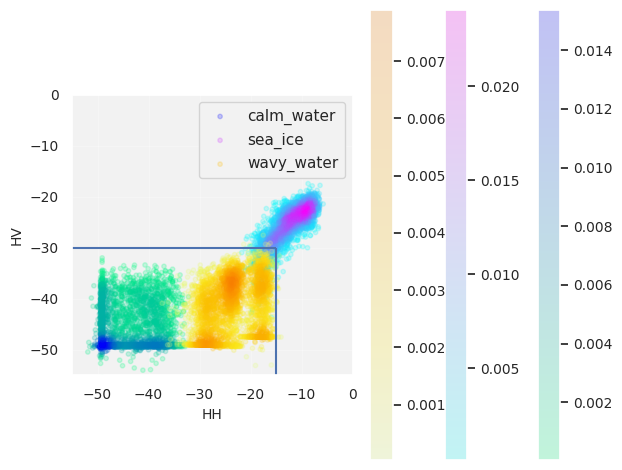

In [29]:
from scipy.stats import gaussian_kde
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density

HHth = -15
HVth = -30
feature_types = df.index
print(feature_types)
cmaps = ['winter_r',
         'cool',
         'Wistia'
          ]
for i, feature in enumerate(feature_types):
    hh = df.iloc[i, 0]
    hv = df.iloc[i, 1]

    hhhv = np.vstack([hh,hv])
    z = gaussian_kde(hhhv)(hhhv)

    plt.scatter(hh, hv, c=z, cmap=cmaps[i],
                label=feature_types[i],
                s=10,
                alpha=0.2
                )
    plt.colorbar()


plt.xlim(-55, 0)
plt.ylim(-55, 0)
plt.vlines(HHth, -55, HVth)
plt.hlines(HVth, -55, HHth)
plt.xlabel('HH')
plt.ylabel('HV')
plt.legend()
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal')
plt.tight_layout()

We can see that there is an overlap zone between sea ice and wavy water. We can try to find good thresholds that separates the sea ice from the wavy water classes. We seek for the minimum percentage of sea ice pixels exceeding the thresholds **and** the higher percentage of wavy water pixels included inside those:
$$
\sum_{i}^{N}
$$

Exploring covariance and means

In [31]:
cov_matrices = []
meansHH = []
meansHV = []

for i, row in enumerate(df.iterrows()):
    cov_matrix = np.cov(df.iloc[i, 0], df.iloc[i, 1])
    cov_matrices.append(cov_matrix)
    meansHH.append(np.mean(df.iloc[i, 0]))
    meansHV.append(np.mean(df.iloc[i, 1]))

    print(f"Cov matrix for {feature_types[i]}")
    print(f"{cov_matrix}")
    print(f"Mean HH for {feature_types[i]}: {meansHH[i]:.3f}")
    print(f"Mean HV for {feature_types[i]}: {meansHV[i]:.3f}")
    print("-----------------------")

Cov matrix for calm_water
[[24.32976345  0.66818137]
 [ 0.66818137 20.20928801]]
Mean HH for calm_water: -43.513
Mean HV for calm_water: -45.031
-----------------------
Cov matrix for sea_ice
[[10.4349099   8.89628271]
 [ 8.89628271 12.35701065]]
Mean HH for sea_ice: -12.334
Mean HV for sea_ice: -25.481
-----------------------
Cov matrix for wavy_water
[[21.89207621  6.7642895 ]
 [ 6.7642895  27.29838652]]
Mean HH for wavy_water: -23.564
Mean HV for wavy_water: -41.267
-----------------------


In [32]:
hh_image = sampleimages[0]
hv_image = sampleimages[1]

svalbard_outline = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
    .filter(ee.Filter.eq('country_na', 'Svalbard'))

# Combine HH and HV bands
combined_image = hh_image.addBands(hv_image.select('HV'))

arctic_bounds = ee.Geometry.Rectangle([-10, 74, 40, 82])

# Create inverse geometry (everything in bounds EXCEPT Svalbard)
inverse_geometry = arctic_bounds.difference(svalbard_outline.geometry())

# Clip the combined image to the inverse geometry to exclude land
combined_image_no_land = combined_image.clip(inverse_geometry)


hh = combined_image_no_land.select('HH')
hv = combined_image_no_land.select('HV')

testimage = combined_image_no_land

hhhv = hh.divide(hv).rename('HH_divide_HV') # Renamed for clarity

# Add the HH/HV ratio layer to the map
LateSpringMap.addLayer(hhhv, {'min': -2, 'max': 2}, name='HH/HV Ratio (No Land)') # Added vis params and updated layer name
LateSpringMap

Map(bottom=2545.0, center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position'…

In [33]:
# Access the HH and HV bands from the land-masked combined image
hh_band = combined_image_no_land.select('HH')
hv_band = combined_image_no_land.select('HV')

# Apply the formula: HH / (HV + 10)
# Add 10 to the HV band first
hv_plus_35 = hv_band.add(35)
hh_plus_25 = hh_band.add(25)

# Divide the HH band by the (HV + 10) band
new_index = hv_plus_35.divide(hh_plus_25).rename('HH_div_HV_plus_10')

# Define visualization parameters for the new index
# The range of values for this index is not immediately known,
# so initial visualization parameters might need adjustment after inspection.
# Using a broad range as a starting point.
new_index_vis_params = {
    'min': -1,  # Starting guess for min value
    'max': 1,   # Starting guess for max value
    'palette': ['000000', 'FFFFFF'] # Example palette (black to white)
}


# Add the new index layer to the LateSpringMap
SampleMap
SampleMap.addLayer(new_index, {}, '(HV + 11) / (HV + 1) Index')

# Display the map with the new layer
SampleMap

Map(bottom=2545.0, center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position'…

In [34]:
hh_minus_hv = hh_band.subtract(hv)
hh_plus_hv = hh_band.add(hv)

# Divide the HH band by the (HV + 10) band
ndri_index = hh_minus_hv.divide(hh_plus_hv).rename('NDRI')

# Define visualization parameters for the new index
# The range of values for this index is not immediately known,
# so initial visualization parameters might need adjustment after inspection.
# Using a broad range as a starting point.
ndri_index_vis_params = {
    'min': -1,  # Starting guess for min value
    'max': 1,   # Starting guess for max value
    'palette': ['000000', 'FFFFFF'] # Example palette (black to white)
}


# Add the new index layer to the LateSpringMap
SampleMap.addLayer(ndri_index, {}, 'NDRI Index')

# Display the map with the new layer
SampleMap

Map(bottom=2545.0, center=[78.32673233318731, 22.790622575802143], controls=(WidgetControl(options=['position'…

## Clustering and classifying

*   K-means on samples
*   Gaussian Mixtures on image



In [35]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [36]:
df_grouped = pd.DataFrame({
    'HH': [df['HH'].sum()],
    'HV': [df['HV'].sum()]
})

samplematrix = np.column_stack([
    np.array(df_grouped['HH'].iloc[0]),
    np.array(df_grouped['HV'].iloc[0])
])
samplematrix


array([[-48.51025484, -49.09116965],
       [-49.09594955, -49.09594955],
       [-49.09257551, -44.70397648],
       ...,
       [-29.93263846, -48.93148286],
       [-30.75377717, -49.02473432],
       [-30.4875128 , -49.03034608]])

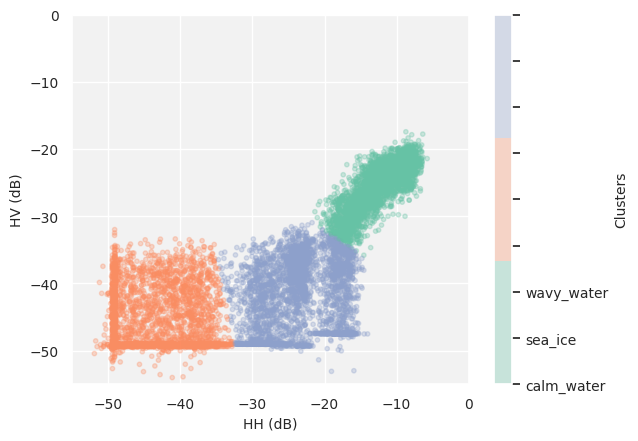

In [37]:
#@title K-means
# DeepSeek helped
from matplotlib.colors import ListedColormap

common_params = {"n_init": "auto",
    "random_state": 67,
    "max_iter" : 1000
}

# train K-means
kmeans = KMeans(n_clusters=3,
                **common_params)
kmeans = kmeans.fit(samplematrix)

cmap=sns.color_palette("Set2", 3)
dcmap = ListedColormap(cmap)
clusters = kmeans.labels_

kmeans_centroids = kmeans.cluster_centers_
samples_centroids = np.column_stack([
    meansHH,
    meansHV
])

plt.scatter(
    samplematrix[:,0],
    samplematrix[:,1],
    c=clusters,
    cmap=dcmap,
    s=10,
    alpha=0.3,
)

plt.xlim(-55, 0)
plt.ylim(-55, 0)
plt.xlabel('HH (dB)')
plt.ylabel('HV (dB)')

cbar = plt.colorbar()
cbar.set_label('Clusters')
cbar.set_ticklabels([f'{feature}' for feature in feature_types])

In [ ]:
def centroids_classification(image, centroids):
    """Classifica immagine EE con centroidi pre-allenati"""

    # Select the bands to use for distance calculation (HH and HV)
    # Ensure the image has these bands
    bands = image.select(['HH', 'HV'])

    # euclidean centroids distances
    distance_bands = []
    for i, centroid in enumerate(centroids):

        # squared difference for HH and HV bands - (bandvalue - bandcentroid)^2
        hh_diff_sq = bands.select('HH').subtract(centroid[0]).pow(2)
        hv_diff_sq = bands.select('HV').subtract(centroid[1]).pow(2)

        # sum squared differences to get squared Euclidean distance
        distance_sq = hh_diff_sq.add(hv_diff_sq).rename(f'dist_{i}')
        distance_bands.append(distance_sq)

    # combine distances in bands
    all_distances = ee.Image.cat(distance_bands)

    # find cluster with minimum distance. Reducer aggregates bands and in this case it finds the minimum band value
    min_distance = all_distances.reduce(ee.Reducer.min())

    # Find the index of the band that equals the minimum distance at each pixel
    # Create a mask for where each band equals the minimum
    masks = all_distances.eq(min_distance)

    # Multiply each band index by its mask and sum up to get the cluster index
    # Create band indices (0, 1, 2...)
    band_indices = ee.Image.constant([i for i in range(len(centroids))])
    # Rename bands for clarity before multiplying with masks
    # Ensure the number of bands in masks matches the number of indices
    mask_band_names = [f'mask_{i}' for i in range(len(centroids))]
    # Check if the number of bands in masks matches the expected number
    #if masks.bandNames().size().getInfo() == len(mask_band_names):
    masks = masks.rename(mask_band_names)
    #else:
        # Fallback or handle if band names don't match
    #    print("Warning: Number of bands in masks does not match the number of centroids. Proceeding without renaming masks.")
    #     pass # Proceed without renaming masks

    # Multiply band indices by their masks
    indexed_masks = masks.multiply(band_indices)

    # Sum across the indexed masks to get the cluster index
    cluster_map = indexed_masks.reduce(ee.Reducer.sum()).rename('cluster')


    # Return the original image with the added cluster map band
    return image.addBands(cluster_map)

In [ ]:
classified_image = centroids_classification(combined_image_no_land, kmeans_centroids)

# Define visualization parameters for the classified image
# Assuming cluster labels are 0, 1, 2... based on centroids
# Get the number of centroids to set max visualization value
num_centroids = len(kmeans_centroids)
classified_vis_params = {
    'min': 0,
    'max': num_centroids - 1,
    'palette': ['#56fcc1', '#1b3f76', '#3e7ce6'] # Example palette
}

SampleMap.addLayer(classified_image.select('cluster'), classified_vis_params, 'Centroid Classification (from sklearn)')
SampleMap

In [ ]:
kmeans_centroids = kmeans.cluster_centers_
print(kmeans_centroids)

samples_centroids = np.column_stack([
    meansHH,
    meansHV
])

In [ ]:
testimage_array = geemap.ee_to_numpy(testimage)
kmeans.predict(testimage_array)